# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [27]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


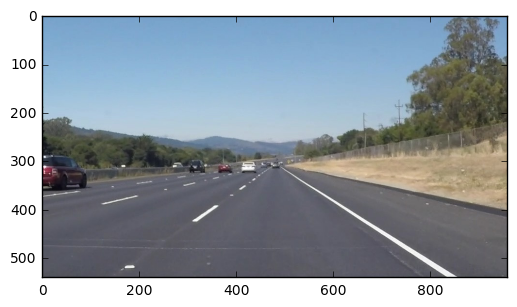

In [28]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [52]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    
    # these variables represent the y-axis coordinates to which the line will be extrapolated to
    ymin_global = img.shape[0]
    ymax_global = img.shape[0]
    
    # left lane line variables
    all_left_grad = []
    all_left_y = []
    all_left_x = []
    
    # right lane line variables
    all_right_grad = []
    all_right_y = []
    all_right_x = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            ymin_global = min(min(y1, y2), ymin_global)
            
            if (gradient > 0):
                all_left_grad += [gradient]
                all_left_y += [y1, y2]
                all_left_x += [x1, x2]
            else:
                all_right_grad += [gradient]
                all_right_y += [y1, y2]
                all_right_x += [x1, x2]
    
    left_mean_grad = np.mean(all_left_grad)
    left_y_mean = np.mean(all_left_y)
    left_x_mean = np.mean(all_left_x)
    left_intercept = left_y_mean - (left_mean_grad * left_x_mean)
    
    right_mean_grad = np.mean(all_right_grad)
    right_y_mean = np.mean(all_right_y)
    right_x_mean = np.mean(all_right_x)
    right_intercept = right_y_mean - (right_mean_grad * right_x_mean)
    
    # Make sure we have some points in each lane line category
    if ((len(all_left_grad) > 0) and (len(all_right_grad) > 0)):
        upper_left_x = int((ymin_global - left_intercept) / left_mean_grad)
        lower_left_x = int((ymax_global - left_intercept) / left_mean_grad)
        upper_right_x = int((ymin_global - right_intercept) / right_mean_grad)
        lower_right_x = int((ymax_global - right_intercept) / right_mean_grad)

        cv2.line(img, (upper_left_x, ymin_global), (lower_left_x, ymax_global), color, thickness)
        cv2.line(img, (upper_right_x, ymin_global), (lower_right_x, ymax_global), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def identify_mark_lane(img):
    originalImage = img;
    gray = grayscale(img)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 50, 150)
    imshape = img.shape
    vertices = np.array([[(150,imshape[0]),(400, 360), (600, 350), (900,imshape[0])]], dtype=np.int32)
    #print(vertices)
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(masked_edges, 5, np.pi/180, 15, 35, 20)

    color_edges = weighted_img(lines, originalImage, 0.9, 3, 0)
    return color_edges

#    plt.imshow(color_edges)


    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

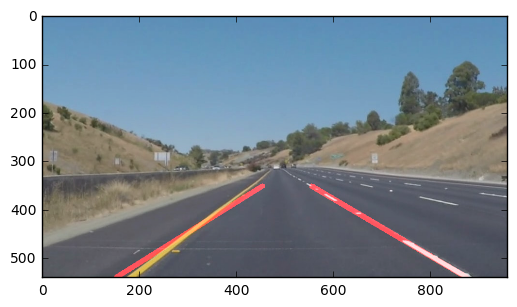

In [53]:
import os

test_images = os.listdir("test_images/")
#print(test_images)
image = mpimg.imread("test_images/" + test_images[5])
#print(image)
#plt.imshow(image)

color_edges = identify_mark_lane(image)
plt.imshow(color_edges)



run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
def process_image(image):
    print(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = identify_mark_lane(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [56]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 43  41  49]
  [ 41  39  47]]

 ..., 
 [[ 83  83  95]
  [ 83  83  95]
  [ 83  83  95]
  ..., 
  [ 90  88  96]
  [ 90  88  96]
  [ 88  86  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ..., 
  [ 88  86  96]
  [ 88  86  96]
  [ 86  84  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ..., 
  [ 85  83  93]
  [ 85  83  93]
  [ 82  80  90]]]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  4%|▍         | 9/222 [00:00<00:02, 83.49it/s]

[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 44  42  50]
  [ 43  41  49]
  [ 41  39  47]]

 ..., 
 [[ 83  83  95]
  [ 83  83  95]
  [ 83  83  95]
  ..., 
  [ 90  88  96]
  [ 90  88  96]
  [ 88  86  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ..., 
  [ 88  86  96]
  [ 88  86  96]
  [ 86  84  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ..., 
  [ 85  83  93]
  [ 85  83  93]
  [ 82  80  90]]]
[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 81  93  89]
  [ 77  89  85]
  [ 70  82  78]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [ 93 105 101]
  [ 90 102  98]
  [ 85  97  93]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ..., 
  [133 143 140]
  [132 142 139]
  [129 139 136]]

 ..., 
 [[ 85  85  97]
  [ 85  85  97]


 13%|█▎        | 28/222 [00:00<00:02, 87.00it/s]

[[[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [114 157 198]
  [115 158 199]
  [107 150 191]]

 [[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [114 157 198]
  [115 158 199]
  [107 150 191]]

 [[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [114 157 198]
  [115 158 199]
  [107 150 191]]

 ..., 
 [[ 80  80  92]
  [ 80  80  92]
  [ 80  80  92]
  ..., 
  [ 87  88  93]
  [ 88  89  94]
  [ 88  89  94]]

 [[ 80  80  92]
  [ 80  80  92]
  [ 80  80  92]
  ..., 
  [ 86  87  90]
  [ 87  88  91]
  [ 87  88  91]]

 [[ 77  77  89]
  [ 77  77  89]
  [ 77  77  89]
  ..., 
  [ 83  84  87]
  [ 83  84  87]
  [ 84  85  88]]]
[[[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [114 157 198]
  [114 157 198]
  [107 150 191]]

 [[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [115 158 199]
  [114 157 198]
  [108 151 192]]

 [[112 162 200]
  [112 162 200]
  [112 162 200]
  ..., 
  [115 158 199]
  [113 156 197]
  [108 151 192]]

 ..., 
 [[ 80  80  90]
  [ 80  80  90]


 21%|██        | 47/222 [00:00<00:02, 82.81it/s]

[[[118 159 202]
  [118 159 202]
  [118 159 202]
  ..., 
  [113 128 142]
  [114 128 140]
  [110 124 136]]

 [[118 159 202]
  [118 159 202]
  [118 159 202]
  ..., 
  [106 121 135]
  [107 121 133]
  [102 116 128]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ..., 
  [ 97 111 121]
  [ 97 109 117]
  [ 93 105 113]]

 ..., 
 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ..., 
  [ 85  83  91]
  [ 85  83  91]
  [ 85  83  91]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..., 
  [ 84  85  88]
  [ 84  85  88]
  [ 84  85  88]]

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ..., 
  [ 81  82  85]
  [ 81  82  85]
  [ 81  82  85]]]
[[[118 159 202]
  [118 159 202]
  [118 159 202]
  ..., 
  [102 116 128]
  [ 96 110 120]
  [ 91 105 115]]

 [[118 159 202]
  [118 159 202]
  [118 159 202]
  ..., 
  [ 99 113 125]
  [ 91 105 115]
  [ 88 102 112]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ..., 
  [ 97 109 117]
  [ 93 103 109]
  [ 90 100 106]]

 ..., 
 [[ 87  87  97]
  [ 87  87  97]


 28%|██▊       | 62/222 [00:00<00:02, 76.70it/s]

[[[115 163 204]
  [114 162 203]
  [112 160 201]
  ..., 
  [ 95  89  80]
  [ 99  94  82]
  [102  97  85]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ..., 
  [ 92  86  77]
  [ 98  93  81]
  [101  96  84]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ..., 
  [ 89  85  77]
  [ 94  89  77]
  [ 97  92  80]]

 ..., 
 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ..., 
  [ 90  88  96]
  [ 90  88  96]
  [ 90  88  96]]

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ..., 
  [ 87  88  93]
  [ 87  88  93]
  [ 87  88  93]]

 [[ 75  78  87]
  [ 75  78  87]
  [ 75  78  87]
  ..., 
  [ 84  85  90]
  [ 84  85  90]
  [ 84  85  90]]]
[[[117 162 204]
  [116 161 203]
  [114 159 201]
  ..., 
  [ 75  74  67]
  [ 76  72  64]
  [ 75  71  63]]

 [[117 162 204]
  [116 161 203]
  [114 159 201]
  ..., 
  [ 79  78  71]
  [ 75  71  63]
  [ 71  67  59]]

 [[117 162 204]
  [116 161 203]
  [114 159 201]
  ..., 
  [ 80  80  75]
  [ 72  71  64]
  [ 68  67  60]]

 ..., 
 [[ 79  79  89]
  [ 79  79  89]


 35%|███▌      | 78/222 [00:00<00:01, 74.78it/s]

[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ..., 
  [108 117 117]
  [ 93 103 109]
  [ 80  90  96]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ..., 
  [ 98 107 107]
  [ 87  97 103]
  [ 79  89  95]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ..., 
  [ 95 102 100]
  [ 89  98 100]
  [ 81  90  92]]

 ..., 
 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ..., 
  [ 89  88  93]
  [ 89  88  93]
  [ 88  87  92]]

 [[ 78  81  88]
  [ 77  80  87]
  [ 77  80  89]
  ..., 
  [ 89  87  95]
  [ 89  87  95]
  [ 88  86  94]]

 [[ 76  79  86]
  [ 77  80  87]
  [ 77  80  89]
  ..., 
  [ 87  85  93]
  [ 86  84  92]
  [ 86  84  92]]]
[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ..., 
  [ 98 101  79]
  [ 92  96  81]
  [ 91  95  80]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ..., 
  [101 104  82]
  [ 96 100  85]
  [ 95  99  84]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ..., 
  [100 103  79]
  [ 98 101  81]
  [ 98 101  81]]

 ..., 
 [[ 77  80  89]
  [ 78  81  90]


 42%|████▏     | 94/222 [00:01<00:01, 74.53it/s]

[[[114 159 201]
  [114 159 201]
  [114 159 201]
  ..., 
  [115 158 197]
  [115 159 195]
  [107 151 187]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ..., 
  [115 158 197]
  [116 160 196]
  [108 152 188]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ..., 
  [115 158 197]
  [116 159 198]
  [108 151 190]]

 ..., 
 [[ 81  81  91]
  [ 83  83  93]
  [ 83  83  93]
  ..., 
  [ 91  89  97]
  [ 89  87  95]
  [ 87  85  93]]

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..., 
  [ 89  89  97]
  [ 87  87  95]
  [ 85  85  93]]

 [[ 79  79  89]
  [ 78  78  88]
  [ 78  78  88]
  ..., 
  [ 87  87  95]
  [ 84  84  92]
  [ 83  83  91]]]
[[[115 158 201]
  [115 158 201]
  [115 158 201]
  ..., 
  [113 156 195]
  [113 157 193]
  [104 148 184]]

 [[115 158 201]
  [115 158 201]
  [115 158 201]
  ..., 
  [113 156 195]
  [114 158 194]
  [106 150 186]]

 [[115 158 201]
  [115 158 201]
  [115 158 201]
  ..., 
  [113 156 195]
  [114 157 196]
  [106 149 188]]

 ..., 
 [[ 81  81  91]
  [ 81  81  91]


 50%|████▉     | 110/222 [00:01<00:01, 72.22it/s]

[[[111 158 202]
  [111 158 202]
  [111 158 202]
  ..., 
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[111 158 202]
  [111 158 202]
  [111 158 202]
  ..., 
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[111 158 202]
  [111 158 202]
  [111 158 202]
  ..., 
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 ..., 
 [[ 83  83  95]
  [ 83  83  95]
  [ 81  81  93]
  ..., 
  [ 88  87  92]
  [ 89  88  93]
  [ 89  88  93]]

 [[ 81  81  93]
  [ 81  81  93]
  [ 78  81  90]
  ..., 
  [ 87  86  91]
  [ 88  87  92]
  [ 88  87  92]]

 [[ 78  78  90]
  [ 77  77  89]
  [ 75  78  87]
  ..., 
  [ 81  80  85]
  [ 82  81  86]
  [ 82  81  86]]]
[[[110 159 202]
  [110 159 202]
  [110 159 202]
  ..., 
  [114 157 198]
  [113 156 197]
  [104 147 188]]

 [[110 159 202]
  [110 159 202]
  [110 159 202]
  ..., 
  [114 157 198]
  [113 156 197]
  [104 147 188]]

 [[110 159 202]
  [110 159 202]
  [110 159 202]
  ..., 
  [114 157 198]
  [113 156 197]
  [104 147 188]]

 ..., 
 [[ 81  81  93]
  [ 81  81  93]


 53%|█████▎    | 118/222 [00:01<00:01, 71.75it/s]

[[[113 158 198]
  [112 157 197]
  [112 157 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [112 157 197]
  [112 157 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [112 157 197]
  [112 157 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 83  83  93]
  [ 84  84  94]
  [ 85  85  95]
  ..., 
  [ 86  87  92]
  [ 84  85  90]
  [ 81  82  87]]

 [[ 82  85  92]
  [ 83  86  93]
  [ 84  87  94]
  ..., 
  [ 83  87  91]
  [ 81  85  89]
  [ 79  83  87]]

 [[ 77  80  87]
  [ 78  81  88]
  [ 78  81  88]
  ..., 
  [ 79  83  87]
  [ 77  81  85]
  [ 76  80  84]]]
[[[110 160 198]
  [109 159 197]
  [109 159 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[110 160 198]
  [109 159 197]
  [109 159 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[110 160 198]
  [109 159 197]
  [109 159 197]
  ..., 
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 86  86  96]
  [ 86  86  96]


 57%|█████▋    | 126/222 [00:01<00:01, 72.27it/s]

[[[114 157 198]
  [114 157 198]
  [113 158 200]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[114 157 198]
  [114 157 198]
  [113 158 200]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[114 157 198]
  [114 157 198]
  [113 158 200]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ..., 
 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..., 
  [ 89  88  93]
  [ 89  88  93]
  [ 89  88  93]]

 [[ 81  84  93]
  [ 81  84  93]
  [ 81  84  93]
  ..., 
  [ 88  87  92]
  [ 88  87  92]
  [ 88  87  92]]

 [[ 78  81  90]
  [ 78  81  90]
  [ 78  81  90]
  ..., 
  [ 86  85  90]
  [ 86  85  90]
  [ 86  85  90]]]
[[[114 157 196]
  [114 157 196]
  [113 158 198]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[114 157 196]
  [114 157 196]
  [113 158 198]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[114 157 196]
  [114 157 196]
  [113 158 198]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 ..., 
 [[ 83  83  93]
  [ 83  83  93]


 60%|██████    | 134/222 [00:01<00:01, 71.13it/s]

[[[113 158 200]
  [113 158 200]
  [113 158 200]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[113 158 200]
  [113 158 200]
  [113 158 200]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[113 158 200]
  [113 158 200]
  [113 158 200]
  ..., 
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 ..., 
 [[ 83  83  93]
  [ 81  81  91]
  [ 79  82  91]
  ..., 
  [ 87  85  93]
  [ 87  85  93]
  [ 86  84  92]]

 [[ 79  82  91]
  [ 78  81  90]
  [ 78  81  90]
  ..., 
  [ 86  85  90]
  [ 86  85  90]
  [ 86  85  90]]

 [[ 77  80  89]
  [ 76  79  88]
  [ 76  79  88]
  ..., 
  [ 83  82  87]
  [ 83  82  87]
  [ 85  84  89]]]
[[[111 159 200]
  [111 159 200]
  [111 159 200]
  ..., 
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ..., 
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ..., 
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 ..., 
 [[ 85  85  95]
  [ 85  85  95]


 64%|██████▍   | 142/222 [00:01<00:01, 70.63it/s]

[[[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ..., 
  [ 89  87  95]
  [ 86  84  92]
  [ 86  84  92]]

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ..., 
  [ 89  88  91]
  [ 85  84  87]
  [ 85  84  87]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..., 
  [ 82  81  84]
  [ 78  77  80]
  [ 78  77  80]]]
[[[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 86  86  96]
  [ 86  86  96]


 68%|██████▊   | 150/222 [00:01<00:01, 70.29it/s]

[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 87  87  97]
  [ 87  87  97]
  [ 87  87  97]
  ..., 
  [ 89  87  95]
  [ 87  85  93]
  [ 86  84  92]]

 [[ 87  90  99]
  [ 87  90  99]
  [ 87  90  99]
  ..., 
  [ 89  88  91]
  [ 87  86  89]
  [ 86  85  88]]

 [[ 83  86  95]
  [ 83  86  95]
  [ 83  86  95]
  ..., 
  [ 85  84  87]
  [ 82  81  84]
  [ 81  80  83]]]
[[[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ..., 
 [[ 87  87  97]
  [ 87  87  97]


 75%|███████▍  | 166/222 [00:02<00:00, 70.21it/s]

[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ..., 
  [115 156 197]
  [113 158 198]
  [107 152 192]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ..., 
  [112 153 194]
  [110 155 195]
  [103 148 188]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ..., 
  [118 155 193]
  [117 156 191]
  [108 147 182]]

 ..., 
 [[ 89  89  97]
  [ 89  89  97]
  [ 89  89  97]
  ..., 
  [ 80  80  88]
  [ 80  80  88]
  [ 80  80  88]]

 [[ 89  92  99]
  [ 89  92  99]
  [ 89  92  99]
  ..., 
  [ 80  81  86]
  [ 80  81  86]
  [ 80  81  86]]

 [[ 84  87  94]
  [ 84  87  94]
  [ 84  87  94]
  ..., 
  [ 74  75  80]
  [ 74  75  80]
  [ 74  75  80]]]
[[[115 158 199]
  [115 158 199]
  [115 158 199]
  ..., 
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 [[115 158 199]
  [115 158 199]
  [115 158 199]
  ..., 
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 [[115 158 199]
  [115 158 199]
  [115 158 199]
  ..., 
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 ..., 
 [[ 87  87  95]
  [ 87  87  95]


 82%|████████▏ | 182/222 [00:02<00:00, 69.83it/s]

[[[110 160 198]
  [110 160 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[110 160 198]
  [110 160 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[110 160 198]
  [110 160 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ..., 
 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..., 
  [ 83  83  91]
  [ 81  81  89]
  [ 81  81  89]]

 [[ 78  83  89]
  [ 78  83  89]
  [ 78  83  89]
  ..., 
  [ 80  81  84]
  [ 80  81  84]
  [ 80  81  84]]

 [[ 77  82  88]
  [ 77  82  88]
  [ 77  82  88]
  ..., 
  [ 76  77  80]
  [ 76  77  80]
  [ 76  77  80]]]
[[[112 160 199]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[112 160 199]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 161 200]
  [111 159 198]
  [111 159 198]
  ..., 
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ..., 
 [[ 81  81  91]
  [ 81  81  91]


 89%|████████▊ | 197/222 [00:02<00:00, 68.01it/s]

[[[110 160 198]
  [110 160 198]
  [110 160 198]
  ..., 
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[110 160 198]
  [110 160 198]
  [110 160 198]
  ..., 
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[110 160 198]
  [110 160 198]
  [110 160 198]
  ..., 
  [115 158 199]
  [111 154 195]
  [106 149 190]]

 ..., 
 [[ 83  88  96]
  [ 84  89  97]
  [ 85  88  97]
  ..., 
  [ 83  81  89]
  [ 83  81  89]
  [ 83  81  89]]

 [[ 86  89  98]
  [ 86  89  98]
  [ 86  89  98]
  ..., 
  [ 81  81  89]
  [ 81  81  89]
  [ 81  81  89]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ..., 
  [ 79  79  87]
  [ 79  79  87]
  [ 79  79  87]]]
[[[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ..., 
  [115 158 199]
  [111 154 195]
  [106 149 190]]

 ..., 
 [[ 83  88  96]
  [ 84  89  97]


 95%|█████████▌| 211/222 [00:02<00:00, 67.85it/s]

[[[111 161 199]
  [111 161 199]
  [111 161 199]
  ..., 
  [111 154 193]
  [113 156 195]
  [104 147 186]]

 [[111 161 199]
  [111 161 199]
  [111 161 199]
  ..., 
  [111 154 193]
  [113 156 195]
  [104 147 186]]

 [[111 161 199]
  [111 161 199]
  [111 161 199]
  ..., 
  [111 154 193]
  [113 156 195]
  [104 147 186]]

 ..., 
 [[ 85  85  95]
  [ 85  85  95]
  [ 87  87  97]
  ..., 
  [ 79  79  87]
  [ 77  77  85]
  [ 76  76  84]]

 [[ 86  86  96]
  [ 85  85  95]
  [ 87  87  97]
  ..., 
  [ 79  79  87]
  [ 77  77  85]
  [ 74  74  82]]

 [[ 83  83  93]
  [ 81  81  91]
  [ 84  84  94]
  ..., 
  [ 76  76  84]
  [ 73  73  81]
  [ 72  72  80]]]
[[[112 160 199]
  [112 160 199]
  [112 160 199]
  ..., 
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[112 160 199]
  [112 160 199]
  [112 160 199]
  ..., 
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[112 160 199]
  [112 160 199]
  [112 160 199]
  ..., 
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ..., 
 [[ 85  85  95]
  [ 85  85  95]


100%|█████████▉| 221/222 [00:03<00:00, 72.63it/s]


[[[110 158 199]
  [110 158 199]
  [110 158 199]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ..., 
  [113 156 197]
  [111 154 195]
  [106 149 190]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ..., 
  [111 154 195]
  [111 154 195]
  [106 149 190]]

 ..., 
 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ..., 
  [ 79  79  91]
  [ 79  79  91]
  [ 79  79  91]]

 [[ 88  88  98]
  [ 88  88  98]
  [ 88  88  98]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 76  79  90]]

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..., 
  [ 75  78  89]
  [ 74  77  88]
  [ 74  77  88]]]
[[[109 159 199]
  [109 159 199]
  [109 159 199]
  ..., 
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ..., 
  [113 156 197]
  [111 154 195]
  [106 149 190]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ..., 
  [111 154 195]
  [111 154 195]
  [106 149 190]]

 ..., 
 [[ 86  86  96]
  [ 86  86  96]


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 ..., 
 [[103 103 115]
  [103 103 115]
  [103 103 115]
  ..., 
  [ 77  81  94]
  [ 78  82  95]
  [ 76  80  93]]

 [[102 102 112]
  [102 102 112]
  [102 102 112]
  ..., 
  [ 76  80  95]
  [ 76  80  95]
  [ 74  78  93]]

 [[101 101 111]
  [102 102 112]
  [102 102 112]
  ..., 
  [ 76  80  95]
  [ 76  80  95]
  [ 73  77  92]]]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 8/682 [00:00<00:08, 79.22it/s]

[[[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [104 153 198]
  [104 153 198]
  [ 98 147 192]]

 ..., 
 [[103 103 115]
  [103 103 115]
  [103 103 115]
  ..., 
  [ 77  81  94]
  [ 78  82  95]
  [ 76  80  93]]

 [[102 102 112]
  [102 102 112]
  [102 102 112]
  ..., 
  [ 76  80  95]
  [ 76  80  95]
  [ 74  78  93]]

 [[101 101 111]
  [102 102 112]
  [102 102 112]
  ..., 
  [ 76  80  95]
  [ 76  80  95]
  [ 73  77  92]]]
[[[107 159 203]
  [107 159 203]
  [109 158 203]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 98 147 194]]

 [[107 159 203]
  [107 159 203]
  [109 158 203]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 98 147 194]]

 [[107 159 203]
  [107 159 203]
  [109 158 203]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 98 147 194]]

 ..., 
 [[109 107 119]
  [109 107 119]


  4%|▍         | 26/682 [00:00<00:08, 81.32it/s]

[[[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 [[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 [[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 ..., 
 [[112 112 122]
  [112 112 122]
  [110 110 120]
  ..., 
  [ 78  82  95]
  [ 77  81  94]
  [ 76  80  93]]

 [[113 113 123]
  [113 113 123]
  [112 112 122]
  ..., 
  [ 77  81  96]
  [ 75  79  94]
  [ 74  78  93]]

 [[106 106 116]
  [106 106 116]
  [106 106 116]
  ..., 
  [ 76  80  95]
  [ 74  78  93]
  [ 71  75  90]]]
[[[104 156 198]
  [104 156 198]
  [104 156 198]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 [[104 156 198]
  [104 156 198]
  [104 156 198]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [101 155 199]
  [101 155 199]
  [ 93 147 191]]

 ..., 
 [[106 106 116]
  [106 106 116]


  6%|▋         | 44/682 [00:00<00:07, 84.92it/s]

[[[110 154 199]
  [110 154 199]
  [108 155 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 [[110 154 199]
  [110 154 199]
  [108 155 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 [[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 ..., 
 [[103 103 113]
  [103 103 113]
  [103 103 113]
  ..., 
  [ 78  82  97]
  [ 77  81  96]
  [ 76  80  95]]

 [[107 105 113]
  [107 105 113]
  [107 105 113]
  ..., 
  [ 75  82  94]
  [ 75  82  94]
  [ 74  81  93]]

 [[104 102 110]
  [104 102 110]
  [104 102 110]
  ..., 
  [ 72  79  91]
  [ 72  79  91]
  [ 71  78  90]]]
[[[108 155 199]
  [108 155 199]
  [107 156 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 [[108 155 199]
  [108 155 199]
  [107 156 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 [[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [101 155 197]
  [100 154 196]
  [ 94 148 190]]

 ..., 
 [[103 103 113]
  [103 103 113]


  9%|▊         | 59/682 [00:00<00:08, 71.70it/s]

[[[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [102 154 198]
  [101 153 197]
  [ 95 147 191]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [103 155 199]
  [102 154 198]
  [ 96 148 192]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [103 155 199]
  [102 154 198]
  [ 96 148 192]]

 ..., 
 [[100 103 112]
  [100 103 112]
  [100 103 112]
  ..., 
  [ 79  78  93]
  [ 79  78  93]
  [ 79  78  93]]

 [[103 103 111]
  [102 102 110]
  [102 102 110]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 77  80  91]]

 [[100 100 108]
  [100 100 108]
  [100 100 108]
  ..., 
  [ 74  77  88]
  [ 74  77  88]
  [ 75  78  89]]]
[[[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [102 154 198]
  [101 153 197]
  [ 95 147 191]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [103 155 199]
  [102 154 198]
  [ 96 148 192]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [103 155 199]
  [102 154 198]
  [ 96 148 192]]

 ..., 
 [[100 103 112]
  [ 99 102 111]


 11%|█         | 73/682 [00:00<00:09, 65.36it/s]

[[[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 94 150 193]]

 [[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 93 149 192]]

 [[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 93 149 192]]

 ..., 
 [[116 112 121]
  [116 112 121]
  [118 114 123]
  ..., 
  [ 79  78  93]
  [ 78  77  92]
  [ 79  78  93]]

 [[125 118 128]
  [126 119 129]
  [127 120 130]
  ..., 
  [ 75  77  91]
  [ 74  76  90]
  [ 74  76  90]]

 [[120 113 123]
  [120 113 123]
  [121 114 124]
  ..., 
  [ 74  76  90]
  [ 72  74  88]
  [ 74  76  90]]]
[[[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 94 150 193]]

 [[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 93 149 192]]

 [[104 156 198]
  [104 156 198]
  [106 155 198]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 93 149 192]]

 ..., 
 [[127 124 130]
  [129 126 132]


 13%|█▎        | 89/682 [00:01<00:08, 69.71it/s]

[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 96 145 188]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 96 145 188]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 96 145 188]]

 ..., 
 [[105 103 111]
  [105 103 111]
  [105 103 111]
  ..., 
  [ 79  81  95]
  [ 78  80  94]
  [ 78  80  94]]

 [[106 102 111]
  [106 102 111]
  [106 102 111]
  ..., 
  [ 79  82  93]
  [ 79  82  93]
  [ 79  82  93]]

 [[103  99 108]
  [103  99 108]
  [103  99 108]
  ..., 
  [ 75  78  89]
  [ 75  78  89]
  [ 75  78  89]]]
[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [100 152 196]
  [100 152 196]
  [ 94 146 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [100 152 196]
  [100 152 196]
  [ 94 146 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [100 152 196]
  [100 152 196]
  [ 94 146 190]]

 ..., 
 [[104 102 110]
  [104 102 110]


 15%|█▌        | 103/682 [00:01<00:08, 69.11it/s]

[[[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 95 144 187]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 95 144 187]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [102 151 194]
  [102 151 194]
  [ 95 144 187]]

 ..., 
 [[103 103 111]
  [103 103 111]
  [105 105 115]
  ..., 
  [ 76  78  92]
  [ 77  79  93]
  [ 78  80  94]]

 [[102 100 108]
  [103 101 109]
  [103 101 111]
  ..., 
  [ 78  80  94]
  [ 78  80  94]
  [ 78  80  94]]

 [[102 100 108]
  [102 100 108]
  [103 101 111]
  ..., 
  [ 75  77  91]
  [ 75  77  91]
  [ 75  77  91]]]
[[[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [102 151 194]
  [103 152 195]
  [ 97 146 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [102 151 194]
  [103 152 195]
  [ 97 146 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [102 151 194]
  [103 152 195]
  [ 97 146 189]]

 ..., 
 [[103 103 111]
  [103 103 111]


 17%|█▋        | 117/682 [00:01<00:08, 67.56it/s]

[[[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [106 150 195]
  [105 149 194]
  [100 144 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [106 150 195]
  [105 149 194]
  [100 144 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [106 150 195]
  [105 149 194]
  [100 144 189]]

 ..., 
 [[110 109 114]
  [109 108 113]
  [111 108 114]
  ..., 
  [ 78  82  95]
  [ 78  82  95]
  [ 78  82  95]]

 [[112 108 121]
  [109 105 118]
  [111 107 120]
  ..., 
  [ 77  82  92]
  [ 77  82  92]
  [ 77  82  92]]

 [[106 102 115]
  [113 109 122]
  [110 106 119]
  ..., 
  [ 75  80  90]
  [ 75  80  90]
  [ 75  80  90]]]
[[[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [104 151 195]
  [103 150 194]
  [ 98 145 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [104 151 195]
  [103 150 194]
  [ 98 145 189]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [104 151 195]
  [103 150 194]
  [ 98 145 189]]

 ..., 
 [[107 107 115]
  [107 107 115]


 19%|█▉        | 132/682 [00:01<00:07, 69.67it/s]

[[[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [105 149 194]
  [105 149 194]
  [ 98 142 187]]

 [[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [105 149 194]
  [105 149 194]
  [ 98 142 187]]

 [[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [105 149 194]
  [105 149 194]
  [ 98 142 187]]

 ..., 
 [[112 111 116]
  [111 110 115]
  [110 109 114]
  ..., 
  [ 77  79  95]
  [ 77  79  95]
  [ 74  76  92]]

 [[110 109 114]
  [110 109 114]
  [110 109 114]
  ..., 
  [ 77  80  91]
  [ 78  81  92]
  [ 74  77  88]]

 [[109 108 113]
  [109 108 113]
  [108 107 112]
  ..., 
  [ 75  78  89]
  [ 76  79  90]
  [ 71  74  85]]]
[[[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [104 146 192]
  [104 146 192]
  [ 96 138 184]]

 [[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [104 146 192]
  [104 146 192]
  [ 97 139 185]]

 [[110 152 198]
  [110 152 198]
  [108 150 196]
  ..., 
  [106 148 194]
  [104 146 192]
  [ 97 139 185]]

 ..., 
 [[112 111 116]
  [111 110 115]


 20%|██        | 139/682 [00:01<00:08, 64.46it/s]

[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 ..., 
 [[107 105 113]
  [107 105 113]
  [107 105 113]
  ..., 
  [ 78  81  92]
  [ 78  81  92]
  [ 77  80  91]]

 [[107 105 113]
  [107 105 113]
  [107 105 113]
  ..., 
  [ 77  80  89]
  [ 77  80  89]
  [ 75  78  87]]

 [[101  99 107]
  [101  99 107]
  [101  99 107]
  ..., 
  [ 74  77  86]
  [ 74  77  86]
  [ 71  74  83]]]
[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 197]
  [105 149 196]
  [ 96 140 187]]

 ..., 
 [[107 105 113]
  [107 105 113]


 21%|██▏       | 146/682 [00:02<00:08, 63.34it/s]

[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 ..., 
 [[111 109 117]
  [111 109 117]
  [111 109 117]
  ..., 
  [ 76  79  88]
  [ 75  78  87]
  [ 75  78  87]]

 [[112 110 118]
  [112 110 118]
  [112 110 118]
  ..., 
  [ 75  78  87]
  [ 75  78  87]
  [ 75  78  87]]

 [[107 105 113]
  [107 105 113]
  [107 105 113]
  ..., 
  [ 72  75  84]
  [ 72  75  84]
  [ 72  75  84]]]
[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 ..., 
 [[109 107 115]
  [109 107 115]


 22%|██▏       | 153/682 [00:02<00:08, 60.81it/s]

[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 ..., 
 [[109 107 115]
  [109 107 115]
  [109 107 115]
  ..., 
  [ 77  80  91]
  [ 78  81  90]
  [ 77  80  89]]

 [[110 108 116]
  [110 108 116]
  [109 107 115]
  ..., 
  [ 76  79  88]
  [ 76  79  88]
  [ 76  79  88]]

 [[103 101 109]
  [103 101 109]
  [103 101 109]
  ..., 
  [ 72  75  84]
  [ 72  75  84]
  [ 72  75  84]]]
[[[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 [[110 152 198]
  [110 152 198]
  [110 153 196]
  ..., 
  [106 150 195]
  [105 149 194]
  [ 96 140 185]]

 ..., 
 [[103 102 107]
  [103 102 107]


 23%|██▎       | 160/682 [00:02<00:08, 60.53it/s]

[[[106 154 195]
  [106 154 195]
  [106 154 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 [[106 154 195]
  [106 154 195]
  [106 154 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 [[106 154 195]
  [106 154 195]
  [106 154 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 ..., 
 [[100  99 104]
  [101 100 105]
  [101 100 105]
  ..., 
  [ 80  80  92]
  [ 79  79  91]
  [ 79  79  91]]

 [[101  98 104]
  [101  98 104]
  [102  99 105]
  ..., 
  [ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]]

 [[ 96  93  99]
  [ 96  93  99]
  [ 97  94 100]
  ..., 
  [ 75  78  87]
  [ 75  78  87]
  [ 75  78  87]]]
[[[108 153 195]
  [108 153 195]
  [108 153 195]
  ..., 
  [102 152 192]
  [102 152 192]
  [ 95 145 185]]

 [[108 153 195]
  [108 153 195]
  [108 153 195]
  ..., 
  [102 152 192]
  [102 152 192]
  [ 95 145 185]]

 [[108 153 195]
  [108 153 195]
  [108 153 195]
  ..., 
  [102 152 192]
  [102 152 192]
  [ 95 145 185]]

 ..., 
 [[102 101 106]
  [102 101 106]


 24%|██▍       | 167/682 [00:02<00:08, 61.85it/s]

[[[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 [[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 [[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [103 151 192]
  [103 151 192]
  [ 96 144 185]]

 ..., 
 [[103 102 107]
  [103 102 107]
  [103 102 107]
  ..., 
  [ 83  86  97]
  [ 81  84  95]
  [ 76  79  90]]

 [[103 100 106]
  [103 100 106]
  [103 100 106]
  ..., 
  [ 82  85  94]
  [ 81  84  93]
  [ 75  78  87]]

 [[ 96  93  99]
  [ 96  93  99]
  [ 96  93  99]
  ..., 
  [ 79  82  91]
  [ 78  81  90]
  [ 72  75  84]]]
[[[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 152 195]
  [109 152 195]
  [109 152 195]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 ..., 
 [[103 102 107]
  [104 103 108]


 27%|██▋       | 181/682 [00:02<00:07, 64.44it/s]

[[[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 ..., 
 [[100  98 106]
  [100  98 106]
  [100  98 106]
  ..., 
  [ 81  83  97]
  [ 78  80  94]
  [ 77  79  93]]

 [[101  97 106]
  [101  97 106]
  [101  97 106]
  ..., 
  [ 79  82  93]
  [ 77  80  91]
  [ 76  79  90]]

 [[ 95  91 100]
  [ 95  91 100]
  [ 95  91 100]
  ..., 
  [ 75  78  89]
  [ 72  75  86]
  [ 71  74  85]]]
[[[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 98 143 185]]

 ..., 
 [[102 101 106]
  [102 101 106]


 29%|██▊       | 195/682 [00:02<00:07, 64.43it/s]

[[[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [100 147 191]
  [100 147 191]
  [ 94 141 185]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [100 147 191]
  [100 147 191]
  [ 94 141 185]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [100 147 191]
  [100 147 191]
  [ 94 141 185]]

 ..., 
 [[102 103 108]
  [102 103 108]
  [102 103 108]
  ..., 
  [ 82  84  98]
  [ 82  84  98]
  [ 82  84  98]]

 [[102 103 108]
  [102 103 108]
  [102 103 108]
  ..., 
  [ 80  84  97]
  [ 80  84  97]
  [ 80  84  97]]

 [[ 98  99 104]
  [ 98  99 104]
  [ 98  99 104]
  ..., 
  [ 77  81  94]
  [ 77  81  94]
  [ 77  81  94]]]
[[[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 98 142 187]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 98 142 187]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 98 142 187]]

 ..., 
 [[102 103 108]
  [102 103 108]


 31%|███       | 209/682 [00:03<00:07, 61.77it/s]

[[[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 149 194]
  [105 149 194]
  [ 99 143 188]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 98 142 187]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 98 142 187]]

 ..., 
 [[ 99 100 105]
  [ 99 100 105]
  [101 102 107]
  ..., 
  [ 83  85  99]
  [ 79  81  95]
  [ 82  84  98]]

 [[ 99 100 105]
  [ 99 100 105]
  [100 101 106]
  ..., 
  [ 82  87  97]
  [ 78  83  93]
  [ 80  85  95]]

 [[ 95  96 101]
  [ 95  96 101]
  [ 96  97 102]
  ..., 
  [ 77  82  92]
  [ 73  78  88]
  [ 73  78  88]]]
[[[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 99 144 186]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 99 144 186]]

 [[109 151 197]
  [109 151 197]
  [109 151 197]
  ..., 
  [105 150 192]
  [105 150 192]
  [ 99 144 186]]

 ..., 
 [[ 99 100 105]
  [ 99 100 105]


 33%|███▎      | 223/682 [00:03<00:07, 62.79it/s]

[[[107 151 196]
  [107 151 196]
  [107 151 196]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 99 143 188]]

 [[108 152 197]
  [109 153 198]
  [109 153 198]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 99 143 188]]

 [[108 152 197]
  [109 153 198]
  [109 153 198]
  ..., 
  [102 146 191]
  [103 147 192]
  [ 99 143 188]]

 ..., 
 [[ 94  94 102]
  [ 94  94 102]
  [ 94  94 102]
  ..., 
  [ 78  80  94]
  [ 78  80  94]
  [ 77  79  93]]

 [[ 92  95 102]
  [ 92  95 102]
  [ 94  94 102]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 76  79  90]]

 [[ 92  95 102]
  [ 92  95 102]
  [ 94  94 102]
  ..., 
  [ 76  79  90]
  [ 75  78  89]
  [ 74  77  88]]]
[[[108 150 196]
  [108 150 196]
  [108 150 196]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 99 143 188]]

 [[109 151 197]
  [110 152 198]
  [110 152 198]
  ..., 
  [103 147 192]
  [103 147 192]
  [ 99 143 188]]

 [[109 151 197]
  [110 152 198]
  [110 152 198]
  ..., 
  [102 146 191]
  [103 147 192]
  [ 99 143 188]]

 ..., 
 [[ 95  95 103]
  [ 96  96 104]


 35%|███▍      | 238/682 [00:03<00:06, 67.09it/s]

[[[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [105 152 196]
  [103 150 194]
  [ 97 144 188]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [105 152 196]
  [103 150 194]
  [ 97 144 188]]

 [[106 153 197]
  [106 153 197]
  [106 153 197]
  ..., 
  [105 152 196]
  [103 150 194]
  [ 98 145 189]]

 ..., 
 [[ 96  96 104]
  [ 96  96 104]
  [ 96  96 104]
  ..., 
  [ 79  82  93]
  [ 78  81  92]
  [ 78  81  92]]

 [[ 98  98 106]
  [ 98  98 106]
  [ 98  98 106]
  ..., 
  [ 78  81  92]
  [ 77  80  91]
  [ 76  79  90]]

 [[ 94  94 102]
  [ 94  94 102]
  [ 94  94 102]
  ..., 
  [ 76  79  90]
  [ 75  78  89]
  [ 75  78  89]]]
[[[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [107 151 196]
  [105 149 194]
  [ 99 143 188]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [107 151 196]
  [105 149 194]
  [ 99 143 188]]

 [[108 152 197]
  [108 152 197]
  [108 152 197]
  ..., 
  [107 151 196]
  [105 149 194]
  [100 144 189]]

 ..., 
 [[ 96  96 104]
  [ 96  96 104]


 37%|███▋      | 254/682 [00:03<00:06, 69.08it/s]

[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [106 148 194]
  [106 148 194]
  [ 99 141 187]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [106 148 194]
  [104 146 192]
  [ 99 141 187]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [106 148 194]
  [104 146 192]
  [ 99 141 187]]

 ..., 
 [[104 102 110]
  [104 102 110]
  [104 102 110]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 77  80  91]]

 [[104 103 108]
  [104 103 108]
  [104 103 108]
  ..., 
  [ 75  80  88]
  [ 75  80  88]
  [ 75  80  88]]

 [[104 103 108]
  [104 103 108]
  [104 103 108]
  ..., 
  [ 73  78  86]
  [ 73  78  86]
  [ 73  78  86]]]
[[[109 153 198]
  [109 153 198]
  [109 153 198]
  ..., 
  [106 148 194]
  [106 148 194]
  [ 99 141 187]]

 [[109 153 198]
  [109 153 198]
  [109 153 198]
  ..., 
  [106 148 194]
  [104 146 192]
  [ 99 141 187]]

 [[109 153 198]
  [109 153 198]
  [109 153 198]
  ..., 
  [106 148 194]
  [104 146 192]
  [ 99 141 187]]

 ..., 
 [[103 101 109]
  [104 102 110]


 39%|███▉      | 268/682 [00:03<00:06, 67.91it/s]

[[[112 156 201]
  [112 156 201]
  [112 156 201]
  ..., 
  [104 151 195]
  [105 152 196]
  [ 98 145 189]]

 [[112 156 201]
  [112 156 201]
  [112 156 201]
  ..., 
  [104 151 195]
  [104 151 195]
  [ 98 145 189]]

 [[112 156 201]
  [112 156 201]
  [112 156 201]
  ..., 
  [106 150 195]
  [106 150 195]
  [ 99 143 188]]

 ..., 
 [[104 102 110]
  [104 102 110]
  [104 102 110]
  ..., 
  [ 82  85  96]
  [ 82  85  96]
  [ 82  85  96]]

 [[104 103 108]
  [104 103 108]
  [104 103 108]
  ..., 
  [ 78  81  92]
  [ 78  81  92]
  [ 78  81  92]]

 [[102 101 106]
  [102 101 106]
  [102 101 106]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 77  80  91]]]
[[[111 154 197]
  [111 154 197]
  [110 155 197]
  ..., 
  [103 152 195]
  [104 153 196]
  [ 97 146 189]]

 [[111 154 197]
  [111 154 197]
  [110 155 197]
  ..., 
  [103 152 195]
  [103 152 195]
  [ 97 146 189]]

 [[111 154 197]
  [111 154 197]
  [110 155 197]
  ..., 
  [104 151 195]
  [104 151 195]
  [ 97 144 188]]

 ..., 
 [[104 102 110]
  [104 102 110]


 40%|████      | 276/682 [00:04<00:05, 69.19it/s]

[[[105 154 197]
  [105 154 197]
  [106 155 198]
  ..., 
  [104 151 197]
  [103 150 196]
  [ 97 144 190]]

 [[105 154 197]
  [105 154 197]
  [106 155 198]
  ..., 
  [104 151 197]
  [104 151 197]
  [ 98 145 191]]

 [[105 154 197]
  [105 154 197]
  [107 156 199]
  ..., 
  [105 152 198]
  [104 151 197]
  [ 98 145 191]]

 ..., 
 [[ 95  96 101]
  [ 96  97 102]
  [ 99 100 105]
  ..., 
  [ 80  84  97]
  [ 78  82  95]
  [ 74  78  91]]

 [[ 97  96 101]
  [ 97  96 101]
  [100  99 104]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 76  79  90]]

 [[ 96  95 100]
  [ 97  96 101]
  [ 98  97 102]
  ..., 
  [ 70  73  84]
  [ 70  73  84]
  [ 71  74  85]]]
[[[105 154 197]
  [105 154 197]
  [106 155 198]
  ..., 
  [101 153 195]
  [100 152 194]
  [ 94 146 188]]

 [[105 154 197]
  [105 154 197]
  [106 155 198]
  ..., 
  [101 153 195]
  [100 152 194]
  [ 94 146 188]]

 [[105 154 197]
  [105 154 197]
  [107 156 199]
  ..., 
  [101 153 195]
  [100 152 194]
  [ 94 146 188]]

 ..., 
 [[ 93  97 101]
  [ 93  97 101]


 42%|████▏     | 284/682 [00:04<00:05, 70.13it/s]

[[[100 156 199]
  [102 158 201]
  [102 158 201]
  ..., 
  [ 98 154 199]
  [ 97 153 198]
  [ 91 147 192]]

 [[100 156 199]
  [102 158 201]
  [102 158 201]
  ..., 
  [ 98 154 199]
  [ 97 153 198]
  [ 91 147 192]]

 [[100 156 199]
  [102 158 201]
  [102 158 201]
  ..., 
  [ 98 154 199]
  [ 97 153 198]
  [ 91 147 192]]

 ..., 
 [[ 96  99 108]
  [ 96  99 108]
  [ 96  99 108]
  ..., 
  [ 77  81  94]
  [ 77  81  94]
  [ 77  81  94]]

 [[ 94  97 106]
  [ 94  97 106]
  [ 94  97 106]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 77  80  91]]

 [[ 91  94 103]
  [ 91  94 103]
  [ 91  94 103]
  ..., 
  [ 75  78  89]
  [ 75  78  89]
  [ 75  78  89]]]
[[[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 91 147 190]]

 [[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 91 147 190]]

 [[105 157 201]
  [105 157 201]
  [105 157 201]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 91 147 190]]

 ..., 
 [[ 94  97 106]
  [ 96  99 108]


 43%|████▎     | 292/682 [00:04<00:05, 69.19it/s]

[[[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [101 153 197]
  [100 152 196]
  [ 94 146 190]]

 [[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [101 153 197]
  [100 152 196]
  [ 94 146 190]]

 [[105 157 201]
  [105 157 201]
  [105 157 201]
  ..., 
  [101 153 197]
  [100 152 196]
  [ 94 146 190]]

 ..., 
 [[ 94  97 106]
  [ 96  99 108]
  [ 96  99 108]
  ..., 
  [ 78  82  95]
  [ 78  82  95]
  [ 75  79  92]]

 [[ 94  97 106]
  [ 94  97 106]
  [ 94  97 106]
  ..., 
  [ 79  82  93]
  [ 79  82  93]
  [ 75  78  89]]

 [[ 91  94 103]
  [ 91  94 103]
  [ 91  94 103]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 72  75  86]]]
[[[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 [[103 157 201]
  [103 157 201]
  [105 157 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 [[105 157 201]
  [105 157 201]
  [105 157 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 ..., 
 [[ 94  97 106]
  [ 96  99 108]


 44%|████▍     | 300/682 [00:04<00:05, 69.62it/s]

[[[102 156 202]
  [102 156 202]
  [102 156 202]
  ..., 
  [ 95 154 196]
  [ 95 154 196]
  [ 89 148 190]]

 [[102 156 202]
  [102 156 202]
  [102 156 202]
  ..., 
  [ 96 155 197]
  [ 95 154 196]
  [ 89 148 190]]

 [[102 156 202]
  [102 156 202]
  [102 156 202]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 ..., 
 [[ 94  97 106]
  [ 94  97 106]
  [ 96  99 108]
  ..., 
  [ 73  77  90]
  [ 73  77  90]
  [ 73  77  90]]

 [[ 94  97 106]
  [ 94  97 106]
  [ 96  99 108]
  ..., 
  [ 72  75  86]
  [ 72  75  86]
  [ 72  75  86]]

 [[ 89  92 101]
  [ 89  92 101]
  [ 90  93 102]
  ..., 
  [ 71  74  85]
  [ 71  74  85]
  [ 71  74  85]]]
[[[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 96 150 196]
  [ 98 152 198]
  [ 93 147 193]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 92 146 192]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [100 154 200]
  [ 98 152 198]
  [ 91 145 191]]

 ..., 
 [[100  98 106]
  [100  98 106]


 45%|████▌     | 307/682 [00:04<00:05, 68.46it/s]

[[[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 96 150 196]
  [ 98 152 198]
  [ 93 147 193]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 92 146 192]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [100 154 200]
  [ 98 152 198]
  [ 91 145 191]]

 ..., 
 [[100  98 106]
  [100  98 106]
  [100  98 106]
  ..., 
  [ 76  80  93]
  [ 76  80  93]
  [ 76  80  93]]

 [[ 98  94 103]
  [ 98  94 103]
  [ 98  94 103]
  ..., 
  [ 75  79  92]
  [ 75  79  92]
  [ 75  79  92]]

 [[ 95  91 100]
  [ 95  91 100]
  [ 95  91 100]
  ..., 
  [ 73  77  90]
  [ 73  77  90]
  [ 73  77  90]]]
[[[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 96 150 196]
  [ 98 152 198]
  [ 93 147 193]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 92 146 192]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [100 154 200]
  [ 98 152 198]
  [ 91 145 191]]

 ..., 
 [[100 100 110]
  [ 99  99 109]


 46%|████▌     | 315/682 [00:04<00:05, 68.68it/s]

[[[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 96 145 190]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 97 146 191]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 97 146 191]]

 ..., 
 [[100 103 110]
  [100 103 110]
  [100 103 110]
  ..., 
  [ 78  82  95]
  [ 77  81  94]
  [ 77  81  94]]

 [[103 104 109]
  [103 104 109]
  [103 104 109]
  ..., 
  [ 77  81  94]
  [ 77  81  94]
  [ 77  81  94]]

 [[101 102 107]
  [101 102 107]
  [101 102 107]
  ..., 
  [ 73  77  90]
  [ 73  77  90]
  [ 73  77  90]]]


 47%|████▋     | 322/682 [00:04<00:05, 68.31it/s]

[[[105 157 201]
  [104 156 200]
  [104 156 200]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 96 145 190]]

 [[104 156 200]
  [104 156 200]
  [103 155 199]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 96 145 190]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 96 145 190]]

 ..., 
 [[103 106 113]
  [101 104 111]
  [100 103 110]
  ..., 
  [ 77  81  96]
  [ 77  81  96]
  [ 77  81  96]]

 [[103 104 109]
  [102 103 108]
  [102 103 108]
  ..., 
  [ 77  79  93]
  [ 77  79  93]
  [ 77  79  93]]

 [[100 101 106]
  [100 101 106]
  [100 101 106]
  ..., 
  [ 72  74  88]
  [ 72  74  88]
  [ 72  74  88]]]
[[[107 156 201]
  [106 155 200]
  [106 155 200]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 94 146 190]]

 [[106 155 200]
  [106 155 200]
  [105 154 199]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 94 146 190]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 94 146 190]]

 ..., 
 [[103 106 115]
  [101 104 113]


 50%|████▉     | 338/682 [00:04<00:04, 69.01it/s]

[[[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 92 148 191]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 99 155 198]
  [ 98 154 197]
  [ 92 148 191]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 98 154 197]
  [ 98 154 197]
  [ 91 147 190]]

 ..., 
 [[ 96 101 107]
  [ 97 102 108]
  [ 97 102 108]
  ..., 
  [ 83  85  99]
  [ 81  83  97]
  [ 79  81  95]]

 [[101 101 109]
  [100 100 108]
  [ 99  99 107]
  ..., 
  [ 81  83  97]
  [ 78  80  94]
  [ 77  79  93]]

 [[102 102 110]
  [101 101 109]
  [ 99  99 107]
  ..., 
  [ 77  79  93]
  [ 75  77  91]
  [ 74  76  90]]]
[[[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 99 155 198]
  [ 99 155 198]
  [ 92 148 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 99 155 198]
  [ 98 154 197]
  [ 92 148 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 154 197]
  [ 98 154 197]
  [ 91 147 190]]

 ..., 
 [[ 96 101 107]
  [ 97 102 108]


 52%|█████▏    | 352/682 [00:05<00:04, 69.15it/s]

[[[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 95 154 198]
  [ 95 154 198]
  [ 88 147 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 95 154 198]
  [ 95 154 198]
  [ 88 147 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 95 154 198]
  [ 95 154 198]
  [ 88 147 191]]

 ..., 
 [[ 99 102 111]
  [ 99 102 111]
  [ 99 102 111]
  ..., 
  [ 76  83  95]
  [ 76  83  95]
  [ 76  83  95]]

 [[ 99 102 111]
  [ 99 102 111]
  [ 99 102 111]
  ..., 
  [ 75  83  92]
  [ 75  83  92]
  [ 75  83  92]]

 [[ 98 101 110]
  [ 98 101 110]
  [ 98 101 110]
  ..., 
  [ 71  79  88]
  [ 71  79  88]
  [ 71  79  88]]]
[[[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 91 145 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 91 145 191]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 91 145 191]]

 ..., 
 [[101 104 113]
  [101 104 113]


 54%|█████▍    | 367/682 [00:05<00:04, 67.71it/s]

[[[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 98 152 198]
  [ 99 153 199]
  [ 94 148 194]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 98 152 198]
  [ 99 153 199]
  [ 94 148 194]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 99 153 199]
  [ 99 153 199]
  [ 94 148 194]]

 ..., 
 [[108 108 118]
  [107 107 117]
  [106 106 116]
  ..., 
  [ 84  86 100]
  [ 83  85  99]
  [ 79  81  95]]

 [[105 105 115]
  [103 103 113]
  [102 102 112]
  ..., 
  [ 83  87 100]
  [ 82  86  99]
  [ 80  84  97]]

 [[100 100 110]
  [ 99  99 109]
  [ 96  96 106]
  ..., 
  [ 80  84  97]
  [ 77  81  94]
  [ 75  79  92]]]
[[[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [100 152 196]
  [101 153 197]
  [ 96 148 192]]

 [[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [100 152 196]
  [101 153 197]
  [ 96 148 192]]

 [[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 96 148 192]]

 ..., 
 [[106 106 116]
  [106 106 116]


 56%|█████▌    | 383/682 [00:05<00:04, 69.73it/s]

[[[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 93 147 191]]

 [[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 93 147 191]]

 [[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 93 147 191]]

 ..., 
 [[105 105 115]
  [105 105 115]
  [105 105 115]
  ..., 
  [ 81  81  93]
  [ 81  81  93]
  [ 81  81  93]]

 [[105 105 115]
  [105 105 115]
  [105 105 115]
  ..., 
  [ 79  82  93]
  [ 79  82  93]
  [ 79  82  93]]

 [[ 99  99 109]
  [ 99  99 109]
  [ 99  99 109]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 76  79  90]]]
[[[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 97 146 191]]

 [[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 97 146 191]]

 [[106 155 198]
  [106 155 198]
  [106 155 198]
  ..., 
  [103 152 197]
  [103 152 197]
  [ 97 146 191]]

 ..., 
 [[105 105 115]
  [105 105 115]


 58%|█████▊    | 398/682 [00:05<00:03, 71.78it/s]

[[[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 99 155 200]
  [ 98 154 199]
  [ 92 148 193]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 99 155 200]
  [ 98 154 199]
  [ 92 148 193]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 99 155 200]
  [ 98 154 199]
  [ 92 148 193]]

 ..., 
 [[109 105 114]
  [109 105 114]
  [109 105 114]
  ..., 
  [ 82  86  99]
  [ 81  85  98]
  [ 80  84  97]]

 [[112 105 115]
  [111 104 114]
  [111 104 114]
  ..., 
  [ 84  89  99]
  [ 81  86  96]
  [ 80  85  95]]

 [[112 105 115]
  [111 104 114]
  [110 103 113]
  ..., 
  [ 78  83  93]
  [ 76  81  91]
  [ 74  79  89]]]
[[[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [100 154 200]
  [ 99 153 199]
  [ 93 147 193]]

 [[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [ 99 153 199]
  [ 99 153 199]
  [ 92 146 192]]

 [[107 154 200]
  [107 154 200]
  [107 154 200]
  ..., 
  [ 99 153 199]
  [ 98 152 198]
  [ 92 146 192]]

 ..., 
 [[105 105 115]
  [106 106 116]


 61%|██████    | 414/682 [00:06<00:03, 70.93it/s]

[[[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 98 154 199]
  [ 97 153 198]
  [ 91 147 192]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 98 154 199]
  [ 97 153 198]
  [ 91 147 192]]

 [[104 156 200]
  [104 156 200]
  [104 156 200]
  ..., 
  [ 98 152 198]
  [ 98 152 198]
  [ 91 145 191]]

 ..., 
 [[103 103 113]
  [102 102 112]
  [101 101 111]
  ..., 
  [ 78  82  95]
  [ 76  80  93]
  [ 75  79  92]]

 [[100 100 110]
  [100 100 110]
  [ 99  99 109]
  ..., 
  [ 77  82  92]
  [ 75  80  90]
  [ 74  79  89]]

 [[ 95  95 105]
  [ 94  94 104]
  [ 94  94 104]
  ..., 
  [ 74  79  89]
  [ 71  76  86]
  [ 70  75  85]]]
[[[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 96 155 199]
  [ 95 154 198]
  [ 89 148 192]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 96 155 199]
  [ 95 154 198]
  [ 89 148 192]]

 [[106 155 200]
  [106 155 200]
  [106 155 200]
  ..., 
  [ 97 153 198]
  [ 97 153 198]
  [ 90 146 191]]

 ..., 
 [[115 115 125]
  [114 114 124]


 63%|██████▎   | 430/682 [00:06<00:03, 70.98it/s]

[[[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 98 152 196]
  [ 98 152 196]
  [ 92 146 190]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 ..., 
 [[103 101 109]
  [103 101 109]
  [104 102 110]
  ..., 
  [ 80  84  97]
  [ 77  81  94]
  [ 76  80  93]]

 [[ 97 100 107]
  [ 97 100 107]
  [ 98 101 108]
  ..., 
  [ 78  82  95]
  [ 76  80  93]
  [ 75  79  92]]

 [[ 93  96 103]
  [ 93  96 103]
  [ 93  96 103]
  ..., 
  [ 76  80  93]
  [ 74  78  91]
  [ 73  77  90]]]
[[[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 98 152 196]
  [ 98 152 196]
  [ 92 146 190]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 [[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 92 146 190]]

 ..., 
 [[102 100 108]
  [102 100 108]


 65%|██████▌   | 446/682 [00:06<00:03, 70.28it/s]

[[[107 156 199]
  [107 156 199]
  [108 155 199]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 93 145 189]]

 [[107 156 199]
  [107 156 199]
  [108 155 199]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 93 145 189]]

 [[107 156 199]
  [107 156 199]
  [108 155 199]
  ..., 
  [101 153 197]
  [101 153 197]
  [ 93 145 189]]

 ..., 
 [[102 103 108]
  [102 103 108]
  [102 103 108]
  ..., 
  [ 83  85  99]
  [ 84  86 100]
  [ 81  83  97]]

 [[100 104 108]
  [100 104 108]
  [100 104 108]
  ..., 
  [ 83  85  99]
  [ 83  85  99]
  [ 78  80  94]]

 [[ 94  98 102]
  [ 94  98 102]
  [ 94  98 102]
  ..., 
  [ 81  83  97]
  [ 81  83  97]
  [ 76  78  92]]]
[[[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 91 145 189]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 91 145 189]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [ 99 153 197]
  [ 99 153 197]
  [ 91 145 189]]

 ..., 
 [[103 104 109]
  [103 104 109]


 67%|██████▋   | 454/682 [00:06<00:03, 69.93it/s]

[[[107 156 201]
  [107 156 201]
  [107 156 201]
  ..., 
  [ 99 153 195]
  [ 99 153 195]
  [ 91 145 187]]

 [[109 158 203]
  [109 158 203]
  [109 158 203]
  ..., 
  [ 99 153 195]
  [ 99 153 195]
  [ 91 145 187]]

 [[109 158 203]
  [109 158 203]
  [109 158 203]
  ..., 
  [100 154 196]
  [ 99 153 195]
  [ 92 146 188]]

 ..., 
 [[104 103 108]
  [104 103 108]
  [104 103 108]
  ..., 
  [ 84  83  98]
  [ 83  82  97]
  [ 81  80  95]]

 [[100 104 108]
  [100 104 108]
  [100 104 108]
  ..., 
  [ 81  83  97]
  [ 81  83  97]
  [ 78  80  94]]

 [[ 96 100 104]
  [ 96 100 104]
  [ 96 100 104]
  ..., 
  [ 78  80  94]
  [ 77  79  93]
  [ 77  79  93]]]
[[[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [101 155 199]
  [102 154 198]
  [ 95 147 191]]

 [[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [101 155 199]
  [102 154 198]
  [ 95 147 191]]

 [[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [102 154 198]
  [101 153 197]
  [ 95 147 191]]

 ..., 
 [[103 104 109]
  [103 104 109]


 68%|██████▊   | 462/682 [00:06<00:03, 71.18it/s]

[[[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [105 154 199]
  [104 153 198]
  [ 97 146 191]]

 [[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [105 154 199]
  [104 153 198]
  [ 97 146 191]]

 [[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [103 152 197]
  [102 151 196]
  [ 95 144 189]]

 ..., 
 [[106 110 114]
  [106 110 114]
  [106 110 114]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 77  80  91]]

 [[107 107 115]
  [107 107 115]
  [107 107 115]
  ..., 
  [ 81  84  95]
  [ 82  85  96]
  [ 82  85  96]]

 [[103 103 111]
  [103 103 111]
  [103 103 111]
  ..., 
  [ 77  80  91]
  [ 78  81  92]
  [ 78  81  92]]]
[[[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [105 154 199]
  [104 153 198]
  [ 97 146 191]]

 [[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [105 154 199]
  [104 153 198]
  [ 97 146 191]]

 [[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [103 152 197]
  [102 151 196]
  [ 95 144 189]]

 ..., 
 [[106 110 114]
  [106 110 114]


 69%|██████▉   | 470/682 [00:06<00:03, 69.40it/s]

[[[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 91 145 189]]

 [[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 91 145 189]]

 [[108 155 199]
  [108 155 199]
  [108 155 199]
  ..., 
  [ 99 153 197]
  [ 98 152 196]
  [ 91 145 189]]

 ..., 
 [[106 107 112]
  [106 107 112]
  [106 107 112]
  ..., 
  [ 82  85  96]
  [ 82  84  98]
  [ 79  81  95]]

 [[107 105 113]
  [107 105 113]
  [107 105 113]
  ..., 
  [ 82  85  96]
  [ 82  85  96]
  [ 81  84  95]]

 [[103 101 109]
  [103 101 109]
  [103 101 109]
  ..., 
  [ 77  80  91]
  [ 77  80  91]
  [ 76  79  90]]]
[[[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 90 146 189]]

 [[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 90 146 189]]

 [[110 154 199]
  [110 154 199]
  [110 154 199]
  ..., 
  [ 98 154 197]
  [ 97 153 196]
  [ 90 146 189]]

 ..., 
 [[101 105 109]
  [101 105 109]


 70%|██████▉   | 477/682 [00:06<00:03, 68.31it/s]

[[[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [101 155 201]
  [102 154 200]
  [ 95 147 193]]

 [[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [101 155 201]
  [102 154 200]
  [ 95 147 193]]

 [[107 156 199]
  [107 156 199]
  [107 156 199]
  ..., 
  [101 155 201]
  [102 154 200]
  [ 95 147 193]]

 ..., 
 [[101 102 107]
  [101 102 107]
  [101 102 107]
  ..., 
  [ 83  86  97]
  [ 82  85  96]
  [ 81  84  95]]

 [[102 102 110]
  [102 102 110]
  [102 102 110]
  ..., 
  [ 84  89  99]
  [ 81  86  96]
  [ 80  85  95]]

 [[100 100 108]
  [100 100 108]
  [100 100 108]
  ..., 
  [ 81  86  96]
  [ 78  83  93]
  [ 76  81  91]]]
[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [103 155 199]
  [104 153 198]
  [ 97 146 191]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [103 155 199]
  [104 153 198]
  [ 97 146 191]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [103 155 199]
  [104 153 198]
  [ 97 146 191]]

 ..., 
 [[101 102 107]
  [101 102 107]


 71%|███████   | 485/682 [00:07<00:02, 68.92it/s]

[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [104 153 198]
  [104 151 197]
  [ 97 144 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [104 153 198]
  [104 151 197]
  [ 97 144 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [104 153 198]
  [104 151 197]
  [ 97 144 190]]

 ..., 
 [[101 102 107]
  [101 102 107]
  [101 102 107]
  ..., 
  [ 83  86  97]
  [ 81  84  95]
  [ 81  84  95]]

 [[102 102 110]
  [102 102 110]
  [102 102 110]
  ..., 
  [ 82  87  97]
  [ 80  85  95]
  [ 80  85  95]]

 [[100 100 108]
  [100 100 108]
  [100 100 108]
  ..., 
  [ 76  81  91]
  [ 76  81  91]
  [ 75  80  90]]]
[[[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [105 152 198]
  [106 150 197]
  [ 99 143 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [105 152 198]
  [106 150 197]
  [ 99 143 190]]

 [[107 154 198]
  [107 154 198]
  [107 154 198]
  ..., 
  [105 152 198]
  [106 150 197]
  [ 99 143 190]]

 ..., 
 [[102 103 108]
  [102 103 108]


 72%|███████▏  | 492/682 [00:07<00:02, 68.33it/s]

[[[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 96 145 192]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 96 145 192]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [104 153 200]
  [104 153 200]
  [ 96 145 192]]

 ..., 
 [[102 102 112]
  [102 102 112]
  [103 103 113]
  ..., 
  [ 77  79  93]
  [ 78  80  94]
  [ 77  79  93]]

 [[101 101 111]
  [100 100 110]
  [ 99  99 109]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 76  79  90]]

 [[ 99  99 109]
  [ 99  99 109]
  [ 96  96 106]
  ..., 
  [ 72  75  86]
  [ 72  75  86]
  [ 72  75  86]]]
[[[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 [[105 157 199]
  [105 157 199]
  [105 157 199]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 ..., 
 [[103 103 111]
  [103 103 111]


 73%|███████▎  | 499/682 [00:07<00:02, 67.69it/s]

[[[105 157 201]
  [105 157 201]
  [107 156 201]
  ..., 
  [105 152 196]
  [105 152 196]
  [ 97 144 188]]

 [[105 157 201]
  [105 157 201]
  [107 156 201]
  ..., 
  [105 152 196]
  [105 152 196]
  [ 97 144 188]]

 [[105 157 201]
  [105 157 201]
  [107 156 201]
  ..., 
  [105 152 196]
  [105 152 196]
  [ 97 144 188]]

 ..., 
 [[106 106 114]
  [105 105 113]
  [105 105 113]
  ..., 
  [ 81  83  97]
  [ 79  81  95]
  [ 79  81  95]]

 [[103 103 111]
  [103 103 111]
  [102 102 110]
  ..., 
  [ 79  82  93]
  [ 79  82  93]
  [ 79  82  93]]

 [[ 98  98 106]
  [ 98  98 106]
  [ 98  98 106]
  ..., 
  [ 76  79  90]
  [ 76  79  90]
  [ 76  79  90]]]
[[[109 158 203]
  [109 158 203]
  [110 157 203]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 [[109 158 203]
  [109 158 203]
  [110 157 203]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 [[109 158 203]
  [109 158 203]
  [110 157 203]
  ..., 
  [102 154 198]
  [102 154 198]
  [ 94 146 190]]

 ..., 
 [[103 103 111]
  [103 103 111]


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))